In [29]:
import os
import glob
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os import path
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import imgaug.augmenters as iaa
import cv2


%matplotlib inline

print(os.listdir())

['chest_xray', 'README.md']


In [30]:
data_dir = Path('chest_xray')

In [31]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [32]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')


train_data = []

# Normal - label: 0
for img in normal_cases:
    train_data.append((img,0))

# Normal - label: 1
for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(
    train_data, 
    columns = ['image', 'label'],
    index = None
)

# Shuffle 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,chest_xray\train\PNEUMONIA\person441_virus_894...,1
1,chest_xray\train\PNEUMONIA\person1935_bacteria...,1
2,chest_xray\train\PNEUMONIA\person1545_bacteria...,1
3,chest_xray\train\PNEUMONIA\person1289_bacteria...,1
4,chest_xray\train\NORMAL\IM-0707-0001.jpeg,0


1    3875
0    1341
Name: label, dtype: int64


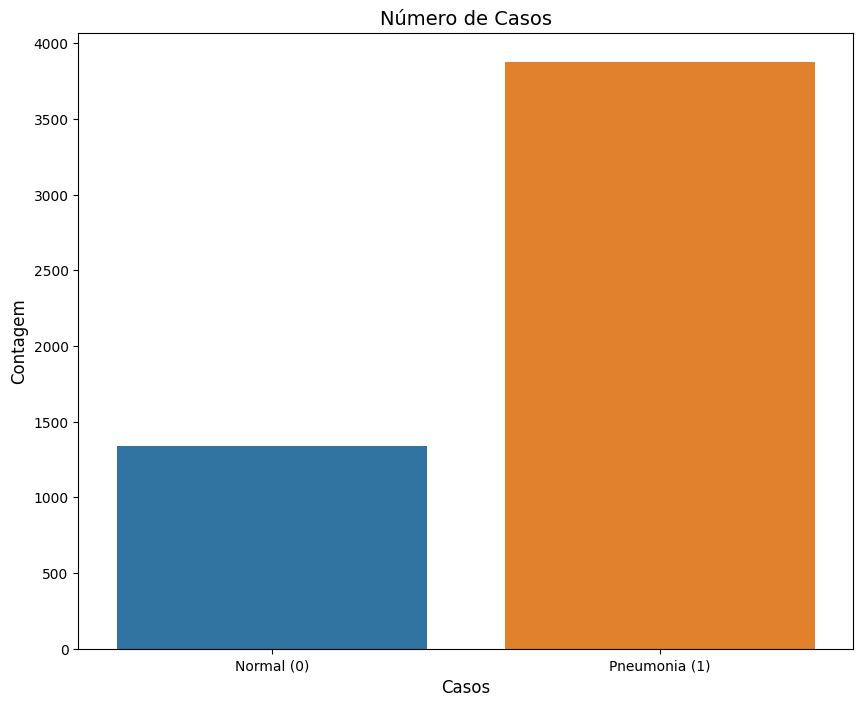

In [33]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize = (10,8))
sns.barplot(x = cases_count.index, y = cases_count.values)
plt.title('Número de Casos', fontsize=14)
plt.xlabel('Casos', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

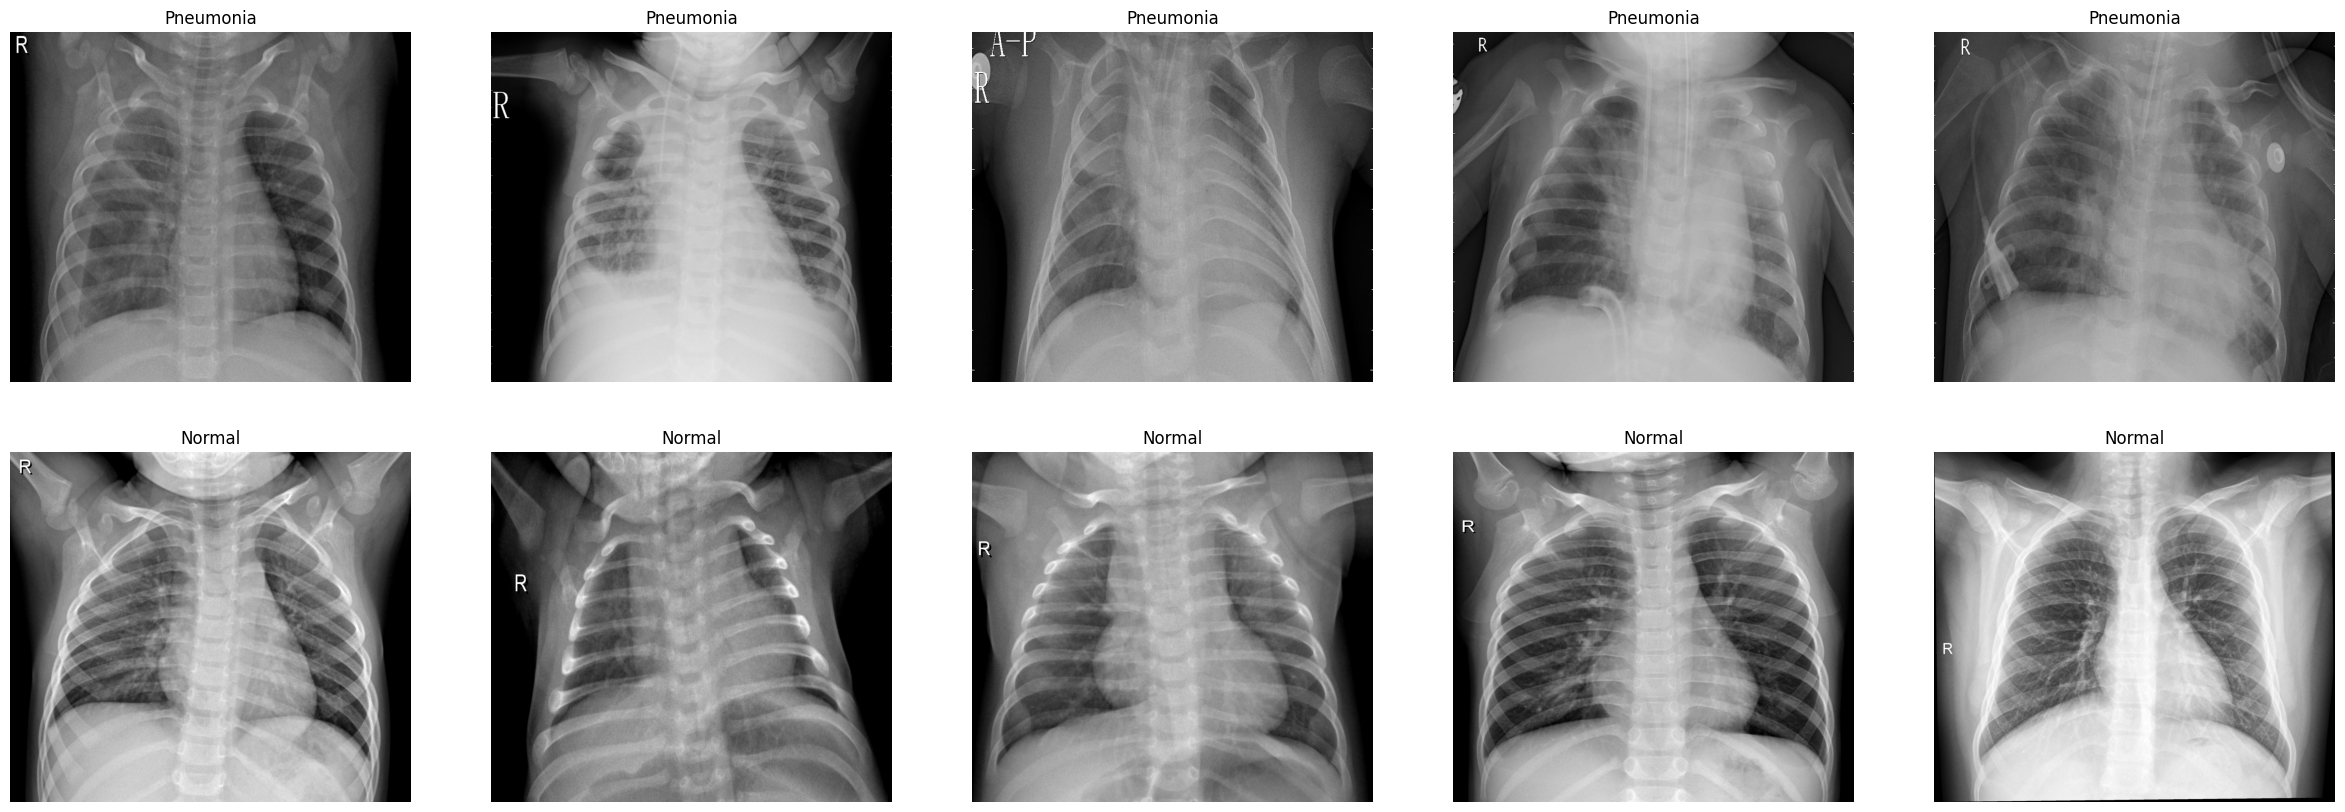

In [34]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))

for i in range(10):
    
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
        
    else:
        ax[i//5, i%5].set_title("Normal")
        
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
    
plt.show()

In [35]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

In [123]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_train_bs = []
y_train_bs = []


# Deixando na dim 224 x 224

# Normal 
for img in normal_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
        
    label = to_categorical(0, num_classes = 2)
    x_train_bs.append(img)
    y_train_bs.append(label)
                      
# Pneumonia 
for img in pneumonia_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    label = to_categorical(1, num_classes = 2)
    x_train_bs.append(img)
    y_train_bs.append(label)
    
x_train_bs = np.array(x_train_bs)
y_train_bs = np.array(y_train_bs)

In [125]:
x_train_bs.shape, y_train_bs.shape

((5216, 224, 224, 3), (5216, 2))

In [ ]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val_bs = []
y_val_bs = []

# Normal 
for img in normal_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    label = to_categorical(0, num_classes = 2)
    x_val_bs.append(img)
    y_val_bs.append(label)
                      
# Pneumonia         
for img in pneumonia_cases:
    
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    label = to_categorical(1, num_classes = 2)
    x_val_bs.append(img)
    y_val_bs.append(label)
    
x_val_bs = np.array(x_val_bs)
y_val_bs = np.array(y_val_bs)

In [ ]:
x_val_bs.shape, y_val_bs.shape

((16, 224, 224, 3), (16, 2))

# Baseline Model

In [ ]:
cnn_bs = tf.keras.models.Sequential()

cnn_bs.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape = (224,224,3)))
cnn_bs.add(MaxPooling2D((2,2)))
cnn_bs.add(Flatten())
cnn_bs.add(Dense(units = 128, activation = 'relu'))
cnn_bs.add(Dense(units = 2, activation = 'sigmoid'))

In [ ]:
cnn_bs.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_bs = cnn_bs.fit(x_train_bs, y_train_bs, epochs = 15, validation_data = (x_val_bs, y_val_bs))

Epoch 1/15
163/163 [==============================] - 56s 344ms/step - loss: 194.4938 - recall: 0.8673 - val_loss: 24.6100 - val_recall: 0.9375
Epoch 2/15
163/163 [==============================] - 55s 340ms/step - loss: 1.9413 - recall: 0.9697 - val_loss: 3.5408 - val_recall: 0.7500
Epoch 3/15
163/163 [==============================] - 56s 342ms/step - loss: 0.4254 - recall: 0.9862 - val_loss: 6.0022 - val_recall: 0.8750
Epoch 4/15
163/163 [==============================] - 56s 341ms/step - loss: 0.4189 - recall: 0.9870 - val_loss: 5.0838 - val_recall: 1.0000
Epoch 5/15
163/163 [==============================] - 56s 342ms/step - loss: 0.3058 - recall: 0.9893 - val_loss: 17.6990 - val_recall: 0.6875
Epoch 6/15
163/163 [==============================] - 57s 347ms/step - loss: 0.0470 - recall: 0.9973 - val_loss: 3.7510 - val_recall: 0.9375
Epoch 7/15
163/163 [==============================] - 58s 359ms/step - loss: 0.0489 - recall: 0.9969 - val_loss: 17.6454 - val_recall: 0.6875
Epoch 8/

In [ ]:
cnn_bs.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 50,468,098
Trainable params: 50,468,098
Non-trainable params: 0
____________________________________________

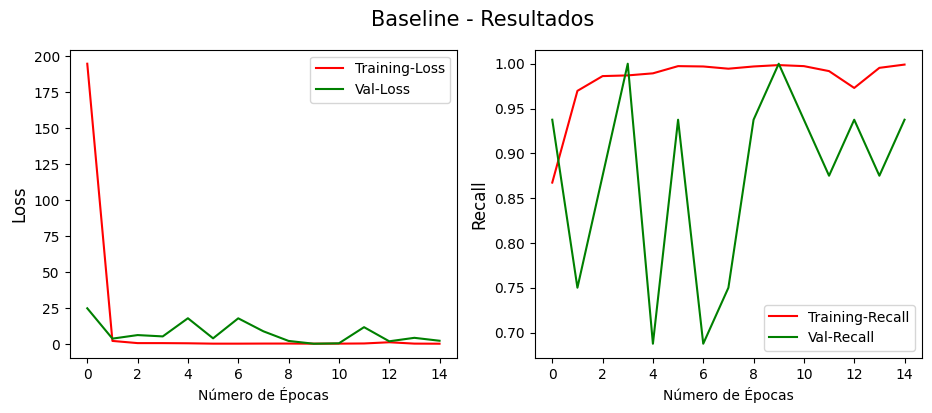

In [119]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("Baseline - Resultados", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_bs.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_bs.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_bs.history['recall'], color = 'r', label = 'Training-Recall')
plt.plot(hist_bs.history['val_recall'], color = 'g', label = 'Val-Recall')
plt.legend(loc = 'best')
plt.show()

# Training models

In [ ]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_train = []
y_train = []


# Deixando na escala de 3 canais (algumas estavam na escala de cinza, mas a maioria nao) e padronizando pelo max (255)

# Normal 
for img in normal_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_train.append(img)
    y_train.append(label)
                      
# Pneumonia         
for img in pneumonia_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes = 2)
    x_train.append(img)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val = []
y_val = []

# Deixando na escala de 3 canais (algumas estavam na escala de cinza, mas a maioria nao) e padronizando pelo max (255)

# Normal 
for img in normal_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_val.append(img)
    y_val.append(label)
                      
# Pneumonia         
for img in pneumonia_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    x_val.append(img)
    y_val.append(label)
    
x_val = np.array(x_val)
y_val = np.array(y_val)

In [37]:
m1_ = tf.keras.models.Sequential()

m1_.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (224, 224, 3)))
m1_.add(MaxPooling2D(pool_size = 2, strides = 2))
m1_.add(Flatten())
m1_.add(Dense(units = 128, activation = 'relu'))
m1_.add(Dense(units = 2, activation = 'sigmoid'))

m1_.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m1_ = m1_.fit(
    x_train,
    y_train, 
    epochs = 15, 
    validation_data = (x_val, y_val)
)

Epoch 1/15
163/163 [==============================] - 57s 348ms/step - loss: 1.0260 - recall_2: 0.8832 - val_loss: 0.2575 - val_recall_2: 0.8750
Epoch 2/15
163/163 [==============================] - 57s 347ms/step - loss: 0.0732 - recall_2: 0.9757 - val_loss: 0.1937 - val_recall_2: 0.9375
Epoch 3/15
163/163 [==============================] - 55s 339ms/step - loss: 0.0481 - recall_2: 0.9837 - val_loss: 0.1318 - val_recall_2: 0.9375
Epoch 4/15
163/163 [==============================] - 55s 340ms/step - loss: 0.0358 - recall_2: 0.9900 - val_loss: 0.1089 - val_recall_2: 0.9375
Epoch 5/15
163/163 [==============================] - 55s 340ms/step - loss: 0.0224 - recall_2: 0.9950 - val_loss: 0.0872 - val_recall_2: 0.9375
Epoch 6/15
163/163 [==============================] - 56s 343ms/step - loss: 0.0087 - recall_2: 0.9992 - val_loss: 0.1461 - val_recall_2: 0.9375
Epoch 7/15
163/163 [==============================] - 56s 342ms/step - loss: 0.0052 - recall_2: 1.0000 - val_loss: 0.1178 - val_re

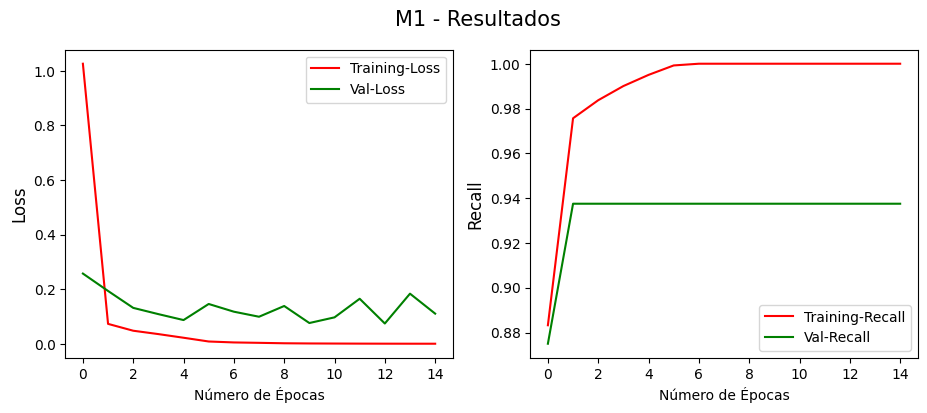

In [118]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M1 - Resultados", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_m1_.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m1_.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m1_.history['recall_2'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m1_.history['val_recall_2'], color = 'g', label = 'Val-Recall')
plt.legend(loc = 'best')
plt.show()

In [42]:
m2_ = tf.keras.models.Sequential()

m2_.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
m2_.add(MaxPooling2D((2, 2)))
m2_.add(Conv2D(64, (3, 3), activation = 'relu'))
m2_.add(MaxPooling2D((2, 2)))
m2_.add(Flatten())
m2_.add(Dense(128, activation = 'relu'))
m2_.add(Dense(2, activation = 'sigmoid'))

m2_.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m2_ = m2_.fit(
    x_train,
    y_train, 
    epochs = 15, 
    validation_data = (x_val, y_val)
)

Epoch 1/15
163/163 [==============================] - 81s 496ms/step - loss: 0.2802 - recall_3: 0.9045 - val_loss: 0.4517 - val_recall_3: 0.8125
Epoch 2/15
163/163 [==============================] - 80s 489ms/step - loss: 0.0873 - recall_3: 0.9695 - val_loss: 0.8219 - val_recall_3: 0.6875
Epoch 3/15
163/163 [==============================] - 82s 501ms/step - loss: 0.0731 - recall_3: 0.9755 - val_loss: 0.2719 - val_recall_3: 0.8125
Epoch 4/15
163/163 [==============================] - 81s 495ms/step - loss: 0.0399 - recall_3: 0.9872 - val_loss: 0.0307 - val_recall_3: 1.0000
Epoch 5/15
163/163 [==============================] - 126s 772ms/step - loss: 0.0397 - recall_3: 0.9849 - val_loss: 0.2984 - val_recall_3: 0.8750
Epoch 6/15
163/163 [==============================] - 141s 862ms/step - loss: 0.0302 - recall_3: 0.9885 - val_loss: 0.1818 - val_recall_3: 0.8750
Epoch 7/15
163/163 [==============================] - 77s 475ms/step - loss: 0.0088 - recall_3: 0.9971 - val_loss: 0.5678 - val_

In [43]:
m2_.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

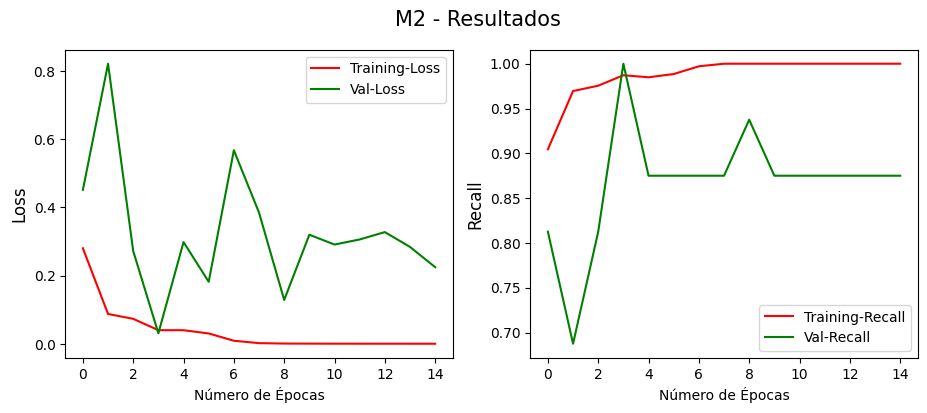

In [117]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M2 - Resultados", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_m2_.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m2_.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m2_.history['recall_3'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m2_.history['val_recall_3'], color = 'g', label = 'Val-Recall')
plt.legend(loc = 'best')
plt.show()

In [45]:
m3_ = tf.keras.models.Sequential()

m3_.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
m3_.add(MaxPooling2D((2, 2)))
m3_.add(Dropout(0.2))
m3_.add(Conv2D(64, (3, 3), activation = 'relu'))
m3_.add(MaxPooling2D((2, 2)))
m3_.add(Dropout(0.2))
m3_.add(Flatten())
m3_.add(Dense(128, activation = 'relu'))
m3_.add(Dense(2, activation = 'sigmoid'))

m3_.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m3_ = m3_.fit(
    x_train,
    y_train, 
    epochs = 15, 
    validation_data = (x_val, y_val)
)

Epoch 1/15
163/163 [==============================] - 85s 522ms/step - loss: 0.5325 - recall_4: 0.8646 - val_loss: 0.3198 - val_recall_4: 0.8125
Epoch 2/15
163/163 [==============================] - 85s 522ms/step - loss: 0.1136 - recall_4: 0.9557 - val_loss: 0.2276 - val_recall_4: 0.8125
Epoch 3/15
163/163 [==============================] - 85s 522ms/step - loss: 0.0866 - recall_4: 0.9699 - val_loss: 0.1591 - val_recall_4: 0.9375
Epoch 4/15
163/163 [==============================] - 85s 520ms/step - loss: 0.0724 - recall_4: 0.9728 - val_loss: 0.1697 - val_recall_4: 0.9375
Epoch 5/15
163/163 [==============================] - 86s 525ms/step - loss: 0.0612 - recall_4: 0.9758 - val_loss: 0.0608 - val_recall_4: 1.0000
Epoch 6/15
163/163 [==============================] - 85s 523ms/step - loss: 0.0501 - recall_4: 0.9827 - val_loss: 0.2791 - val_recall_4: 0.7500
Epoch 7/15
163/163 [==============================] - 85s 524ms/step - loss: 0.0341 - recall_4: 0.9883 - val_loss: 0.2737 - val_re

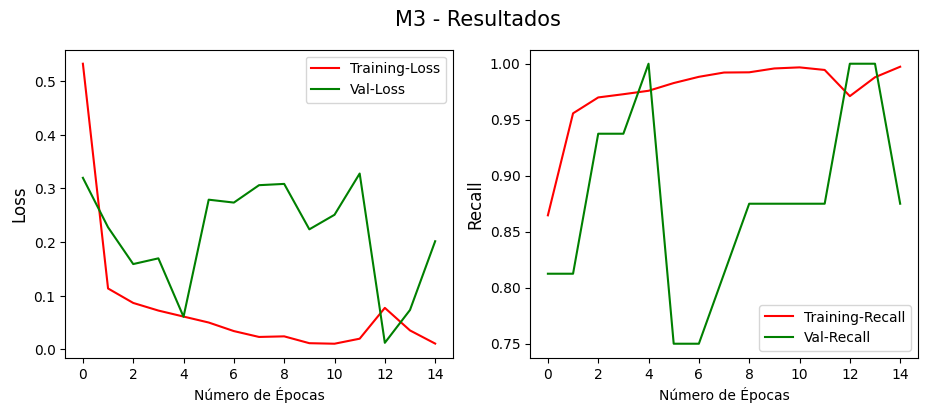

In [116]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M3 - Resultados", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_m3_.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m3_.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m3_.history['recall_4'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m3_.history['val_recall_4'], color = 'g', label = 'Val-Recall')
plt.legend(loc = 'best')
plt.show()

### Data Augmentation

In [47]:
# Augmentation  
seq = iaa.OneOf([
    iaa.Fliplr(), 
    iaa.Affine(rotate = 10), # rotacao
    iaa.Multiply((1.2, 1.5))]) # brilho

In [48]:
def data_gen_rgb(data, batch_size):
    
    n = len(data)
    steps = n // batch_size
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype = np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype = np.float32)
    indices = np.arange(n)
    
    i = 0
    
    while True:
        
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        
        for j, idx in enumerate(next_batch):
            
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # ohe
            encoded_label = to_categorical(label, num_classes=2)
            
            # img 
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # escala de cinza
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # normalize max (255.)
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # geracao de imgs (da cat undersampled)
            if label == 0 and count < batch_size-2:
                
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                
                count +=2
            
            else:
                count += 1
            
            if count == batch_size-1:
                break
            
        i += 1
        yield batch_data, batch_labels
            
        if i >= steps:
            i = 0

In [54]:
def data_gen_gray(data, batch_size):
    
    n = len(data)
    steps = n // batch_size
    batch_data = np.zeros((batch_size, 224, 224), dtype = np.float32)
    batch_labels = np.zeros((batch_size,2), dtype = np.float32)
    indices = np.arange(n)

    i = 0
    
    while True:
        
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        
        for j, idx in enumerate(next_batch):
            
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # ohe
            encoded_label = to_categorical(label, num_classes = 2)
            
            # escala de cinza
            img = cv2.imread(str(img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            
            # normalize max (255.)
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # geracao de imgs (da cat undersampled)
            if label == 0 and count < batch_size-2:
                
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                                
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                
                count +=2
            
            else:
                count += 1
            
            if count == batch_size-1:
                break
            
        i += 1
        
        yield batch_data, batch_labels
            
        if i >= steps:
            i = 0

In [50]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val_gray = []
y_val_gray = []

# Normal 
for img in normal_cases:
    
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_val_gray.append(img)
    y_val_gray.append(label)
                      
# Pneumonia         
for img in pneumonia_cases:

    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))

    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes = 2)
    x_val_gray.append(img)
    y_val_gray.append(label)
    
x_val_gray = np.array(x_val_gray)
y_val_gray = np.array(y_val_gray)

In [51]:
x_val_gray.shape, y_val_gray.shape

((16, 224, 224), (16, 2))

In [55]:
batch_size = 16

train_data_gen_gray = data_gen_gray(data = train_data, batch_size = batch_size)
train_data_gen_rgb = data_gen_rgb(data = train_data, batch_size = batch_size)

nb_train_steps = train_data.shape[0] // batch_size

In [57]:
m1_gray = tf.keras.models.Sequential()

m1_gray.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(224, 224, 1)))
m1_gray.add(MaxPooling2D(pool_size = 2, strides = 2))
m1_gray.add(Flatten())
m1_gray.add(Dense(units = 128, activation = 'relu'))
m1_gray.add(Dense(units = 2, activation = 'sigmoid'))

m1_gray.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m1_gray = m1_gray.fit(
    train_data_gen_gray, 
    epochs = 15, 
    steps_per_epoch = nb_train_steps,
    validation_data = (x_val_gray, y_val_gray)
)

Epoch 1/15
326/326 [==============================] - 77s 235ms/step - loss: 0.7275 - recall_7: 0.8775 - val_loss: 0.3171 - val_recall_7: 0.8750
Epoch 2/15
326/326 [==============================] - 77s 235ms/step - loss: 0.1031 - recall_7: 0.9609 - val_loss: 0.2108 - val_recall_7: 0.9375
Epoch 3/15
326/326 [==============================] - 77s 235ms/step - loss: 0.0624 - recall_7: 0.9776 - val_loss: 0.1243 - val_recall_7: 0.9375
Epoch 4/15
326/326 [==============================] - 77s 235ms/step - loss: 0.0443 - recall_7: 0.9856 - val_loss: 0.2546 - val_recall_7: 0.8125
Epoch 5/15
326/326 [==============================] - 76s 233ms/step - loss: 0.0336 - recall_7: 0.9887 - val_loss: 0.1873 - val_recall_7: 0.9375
Epoch 6/15
326/326 [==============================] - 76s 234ms/step - loss: 0.0380 - recall_7: 0.9864 - val_loss: 0.5974 - val_recall_7: 0.7500
Epoch 7/15
326/326 [==============================] - 77s 235ms/step - loss: 0.0247 - recall_7: 0.9921 - val_loss: 0.0523 - val_re

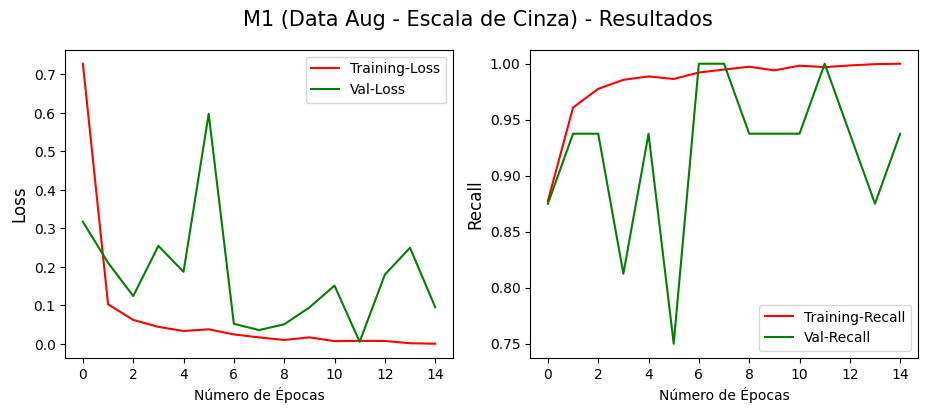

In [120]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M1 (Data Aug - Escala de Cinza) - Resultados", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_m1_gray.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m1_gray.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m1_gray.history['recall_7'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m1_gray.history['val_recall_7'], color = 'g', label = 'Val-Recall')
plt.legend(loc = 'best')
plt.show()

In [60]:
m1_rgb = tf.keras.models.Sequential()

m1_rgb.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(224, 224, 3)))
m1_rgb.add(MaxPooling2D(pool_size = 2, strides = 2))
m1_rgb.add(Flatten())
m1_rgb.add(Dense(units = 128, activation = 'relu'))
m1_rgb.add(Dense(units = 2, activation = 'sigmoid'))

m1_rgb.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m1_rgb = m1_rgb.fit(
    train_data_gen_rgb, 
    epochs = 15, 
    steps_per_epoch = nb_train_steps,
    validation_data = (x_val, y_val)
)

Epoch 1/15
326/326 [==============================] - 84s 257ms/step - loss: 0.3859 - recall_8: 0.9153 - val_loss: 0.5393 - val_recall_8: 0.6250
Epoch 2/15
326/326 [==============================] - 82s 251ms/step - loss: 0.1020 - recall_8: 0.9653 - val_loss: 0.0799 - val_recall_8: 1.0000
Epoch 3/15
326/326 [==============================] - 82s 250ms/step - loss: 0.0486 - recall_8: 0.9837 - val_loss: 0.1527 - val_recall_8: 0.9375
Epoch 4/15
326/326 [==============================] - 83s 254ms/step - loss: 0.0427 - recall_8: 0.9845 - val_loss: 0.1297 - val_recall_8: 1.0000
Epoch 5/15
326/326 [==============================] - 82s 253ms/step - loss: 0.0337 - recall_8: 0.9877 - val_loss: 0.0572 - val_recall_8: 1.0000
Epoch 6/15
326/326 [==============================] - 82s 250ms/step - loss: 0.0381 - recall_8: 0.9900 - val_loss: 0.3046 - val_recall_8: 0.8750
Epoch 7/15
326/326 [==============================] - 81s 248ms/step - loss: 0.0263 - recall_8: 0.9923 - val_loss: 0.6325 - val_re

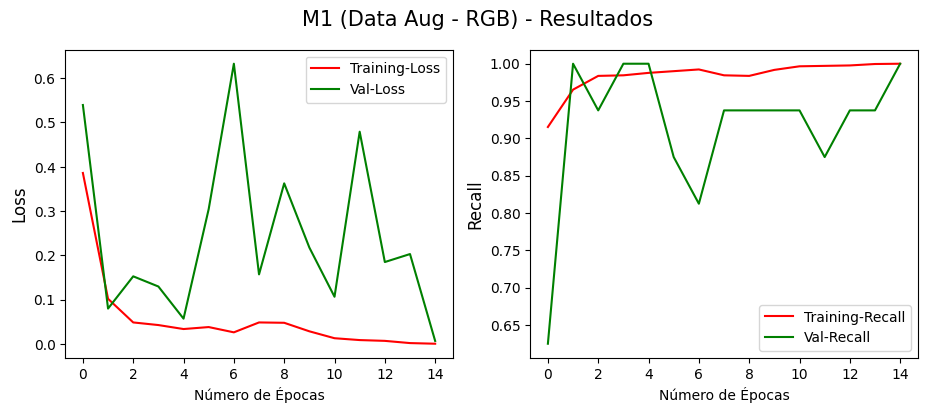

In [121]:
plt.figure(figsize= (11, 4))
plt.subplot(1, 2, 1)
plt.suptitle("M1 (Data Aug - RGB) - Resultados", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize=12)
plt.plot(hist_m1_rgb.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m1_rgb.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize=12)
plt.plot(hist_m1_rgb.history['recall_8'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m1_rgb.history['val_recall_8'], color = 'g', label = 'Val-Recall')
plt.legend(loc='best')
plt.show()

In [71]:
m2_gray = tf.keras.models.Sequential()

m2_gray.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 1)))
m2_gray.add(MaxPooling2D((2, 2)))
m2_gray.add(Conv2D(64, (3, 3), activation = 'relu'))
m2_gray.add(MaxPooling2D((2, 2)))
m2_gray.add(Flatten())
m2_gray.add(Dense(128, activation = 'relu'))
m2_gray.add(Dense(2, activation = 'sigmoid'))

m2_gray.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m2_gray = m2_gray.fit(
    train_data_gen_gray, 
    epochs = 15, 
    steps_per_epoch = nb_train_steps,
    validation_data = (x_val_gray, y_val_gray)
)

Epoch 1/15
326/326 [==============================] - 90s 276ms/step - loss: 0.2261 - recall_12: 0.9189 - val_loss: 0.2028 - val_recall_12: 0.8750
Epoch 2/15
326/326 [==============================] - 89s 274ms/step - loss: 0.0812 - recall_12: 0.9728 - val_loss: 0.0877 - val_recall_12: 0.9375
Epoch 3/15
326/326 [==============================] - 90s 275ms/step - loss: 0.0676 - recall_12: 0.9745 - val_loss: 0.4541 - val_recall_12: 0.7500
Epoch 4/15
326/326 [==============================] - 89s 274ms/step - loss: 0.0552 - recall_12: 0.9812 - val_loss: 0.0904 - val_recall_12: 0.9375
Epoch 5/15
326/326 [==============================] - 138s 424ms/step - loss: 0.0502 - recall_12: 0.9829 - val_loss: 0.9481 - val_recall_12: 0.6875
Epoch 6/15
326/326 [==============================] - 174s 535ms/step - loss: 0.0328 - recall_12: 0.9873 - val_loss: 0.1548 - val_recall_12: 0.8125
Epoch 7/15
326/326 [==============================] - 174s 533ms/step - loss: 0.0232 - recall_12: 0.9918 - val_loss:

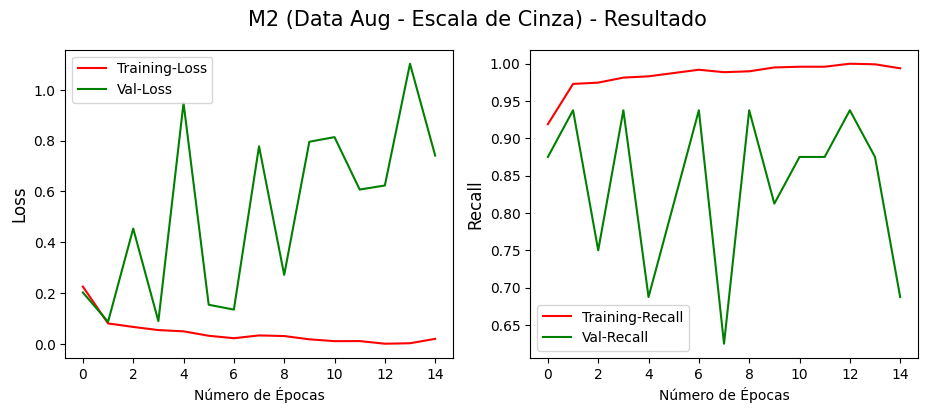

In [74]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M2 (Data Aug - Escala de Cinza) - Resultado", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_m2_gray.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m2_gray.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m2_gray.history['recall_12'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m2_gray.history['val_recall_12'], color = 'g', label = 'Val-Recall')
plt.legend(loc='best')
plt.show()

In [78]:
m2_rgb = tf.keras.models.Sequential()

m2_rgb.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
m2_rgb.add(MaxPooling2D((2, 2)))
m2_rgb.add(Conv2D(64, (3, 3), activation = 'relu'))
m2_rgb.add(MaxPooling2D((2, 2)))
m2_rgb.add(Flatten())
m2_rgb.add(Dense(128, activation = 'relu'))
m2_rgb.add(Dense(2, activation = 'sigmoid'))

m2_rgb.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m2_rgb = m2_rgb.fit(
    train_data_gen_rgb, 
    epochs = 15, 
    steps_per_epoch = nb_train_steps,
    validation_data = (x_val, y_val)
)

Epoch 1/15
326/326 [==============================] - 97s 297ms/step - loss: 0.2882 - recall_15: 0.9076 - val_loss: 0.2385 - val_recall_15: 0.8750
Epoch 2/15
326/326 [==============================] - 97s 298ms/step - loss: 0.0810 - recall_15: 0.9712 - val_loss: 0.2054 - val_recall_15: 0.8750
Epoch 3/15
326/326 [==============================] - 97s 297ms/step - loss: 0.0877 - recall_15: 0.9691 - val_loss: 0.8085 - val_recall_15: 0.6875
Epoch 4/15
326/326 [==============================] - 96s 295ms/step - loss: 0.0497 - recall_15: 0.9841 - val_loss: 0.5825 - val_recall_15: 0.8125
Epoch 5/15
326/326 [==============================] - 158s 486ms/step - loss: 0.0411 - recall_15: 0.9866 - val_loss: 0.0087 - val_recall_15: 1.0000
Epoch 6/15
326/326 [==============================] - 184s 565ms/step - loss: 0.0237 - recall_15: 0.9912 - val_loss: 0.5194 - val_recall_15: 0.9375
Epoch 7/15
326/326 [==============================] - 184s 566ms/step - loss: 0.0159 - recall_15: 0.9942 - val_loss:

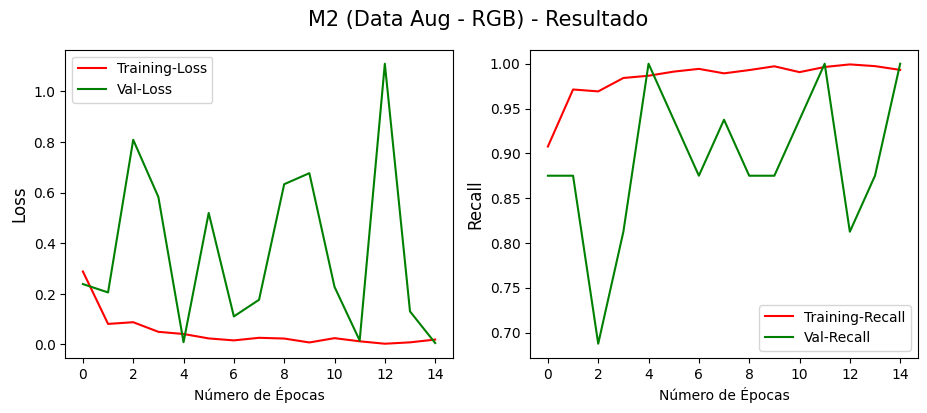

In [82]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M2 (Data Aug - RGB) - Resultado", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_m2_rgb.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m2_rgb.history['val_loss'], color ='g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m2_rgb.history['recall_15'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m2_rgb.history['val_recall_15'], color = 'g', label = 'Val-Recall')
plt.legend(loc='best')
plt.show()

In [84]:
m3_gray = tf.keras.models.Sequential()

m3_gray.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 1)))
m3_gray.add(MaxPooling2D((2, 2)))
m3_gray.add(Dropout(0.2))
m3_gray.add(Conv2D(64, (3, 3), activation = 'relu'))
m3_gray.add(MaxPooling2D((2, 2)))
m3_gray.add(Dropout(0.2))
m3_gray.add(Flatten())
m3_gray.add(Dense(128, activation = 'relu'))
m3_gray.add(Dense(2, activation = 'sigmoid'))

m3_gray.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m3_gray = m3_gray.fit(
    train_data_gen_gray,
    epochs = 15, 
    steps_per_epoch = nb_train_steps,
    validation_data = (x_val_gray, y_val_gray)
)


Epoch 1/15
326/326 [==============================] - 100s 307ms/step - loss: 0.2894 - recall_17: 0.8815 - val_loss: 0.3421 - val_recall_17: 0.8125
Epoch 2/15
326/326 [==============================] - 99s 304ms/step - loss: 0.0882 - recall_17: 0.9697 - val_loss: 0.1524 - val_recall_17: 0.9375
Epoch 3/15
326/326 [==============================] - 99s 305ms/step - loss: 0.0647 - recall_17: 0.9764 - val_loss: 0.1119 - val_recall_17: 0.9375
Epoch 4/15
326/326 [==============================] - 99s 304ms/step - loss: 0.0684 - recall_17: 0.9745 - val_loss: 0.0538 - val_recall_17: 1.0000
Epoch 5/15
326/326 [==============================] - 98s 302ms/step - loss: 0.0554 - recall_17: 0.9812 - val_loss: 0.1363 - val_recall_17: 0.9375
Epoch 6/15
326/326 [==============================] - 99s 304ms/step - loss: 0.0306 - recall_17: 0.9875 - val_loss: 0.1142 - val_recall_17: 0.9375
Epoch 7/15
326/326 [==============================] - 99s 304ms/step - loss: 0.0241 - recall_17: 0.9914 - val_loss: 0

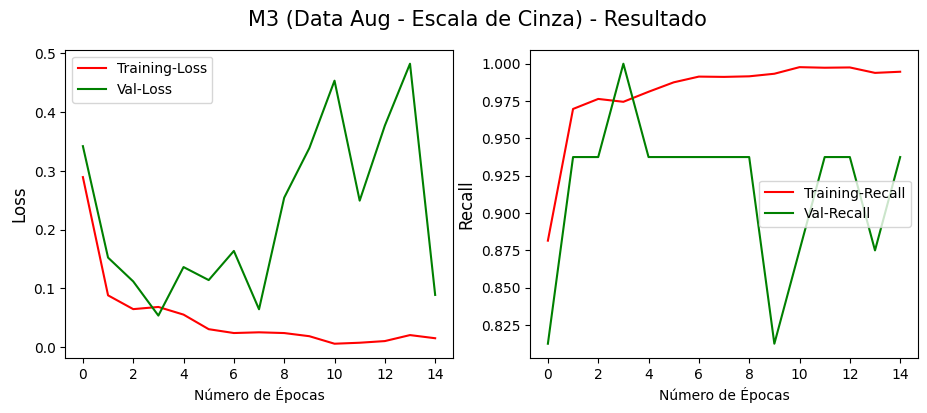

In [114]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M3 (Data Aug - Escala de Cinza) - Resultado", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize = 12)
plt.plot(hist_m3_gray.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m3_gray.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m3_gray.history['recall_17'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m3_gray.history['val_recall_17'], color = 'g', label = 'Val-Recall')
plt.legend(loc='best')
plt.show()

In [88]:
m3_rgb = tf.keras.models.Sequential()

m3_rgb.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
m3_rgb.add(MaxPooling2D((2, 2)))
m3_rgb.add(Dropout(0.2))
m3_rgb.add(Conv2D(64, (3, 3), activation = 'relu'))
m3_rgb.add(MaxPooling2D((2, 2)))
m3_rgb.add(Dropout(0.2))
m3_rgb.add(Flatten())
m3_rgb.add(Dense(128, activation = 'relu'))
m3_rgb.add(Dense(2, activation = 'sigmoid'))

m3_rgb.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Recall())

hist_m3_rgb = m3_rgb.fit(
    train_data_gen_rgb,
    steps_per_epoch = nb_train_steps,
    epochs = 15, 
    validation_data = (x_val, y_val)
)

Epoch 1/15
326/326 [==============================] - 105s 321ms/step - loss: 0.3284 - recall_18: 0.8738 - val_loss: 0.3814 - val_recall_18: 0.8125
Epoch 2/15
326/326 [==============================] - 104s 319ms/step - loss: 0.1023 - recall_18: 0.9636 - val_loss: 0.7817 - val_recall_18: 0.6250
Epoch 3/15
326/326 [==============================] - 104s 319ms/step - loss: 0.0857 - recall_18: 0.9707 - val_loss: 0.0420 - val_recall_18: 1.0000
Epoch 4/15
326/326 [==============================] - 134s 410ms/step - loss: 0.0446 - recall_18: 0.9839 - val_loss: 0.1754 - val_recall_18: 0.9375
Epoch 5/15
326/326 [==============================] - 210s 644ms/step - loss: 0.0435 - recall_18: 0.9873 - val_loss: 0.5911 - val_recall_18: 0.8125
Epoch 6/15
326/326 [==============================] - 200s 614ms/step - loss: 0.0314 - recall_18: 0.9893 - val_loss: 0.4791 - val_recall_18: 0.8750
Epoch 7/15
326/326 [==============================] - 207s 636ms/step - loss: 0.0317 - recall_18: 0.9893 - val_l

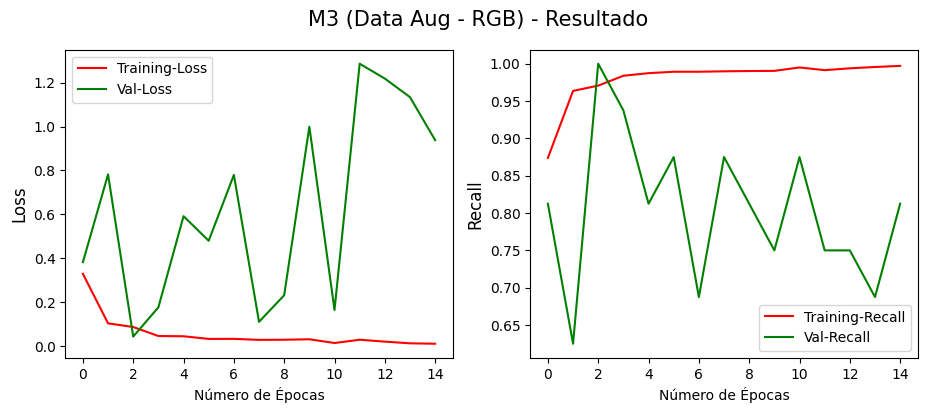

In [115]:
plt.figure(figsize= (11, 4))

plt.subplot(1, 2, 1)
plt.suptitle("M3 (Data Aug - RGB) - Resultado", fontsize = 15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize=12)
plt.plot(hist_m3_rgb.history['loss'], color = 'r', label = 'Training-Loss')
plt.plot(hist_m3_rgb.history['val_loss'], color = 'g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Recall', fontsize = 12)
plt.plot(hist_m3_rgb.history['recall_18'], color = 'r', label = 'Training-Recall')
plt.plot(hist_m3_rgb.history['val_recall_18'], color = 'g', label = 'Val-Recall')
plt.legend(loc='best')
plt.show()

# Test Dataset

In [132]:
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_test = []
y_test = []


# Deixando na escala de 3 canais (algumas estavam na escala de cinza, mas a maioria nao) e padronizando pelo max (255)

# Normal 
for img in normal_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_test.append(img)
    y_test.append(label)
                      
# Pneumonia        
for img in pneumonia_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes = 2)
    x_test.append(img)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [133]:
x_test.shape, y_test.shape

((624, 224, 224, 3), (624, 2))

In [134]:
test_loss, test_score = m1_.evaluate(x_test, y_test)
print(f"Recall no conjunto de teste é {test_score:.2f}")

20/20 [==============================] - 2s 81ms/step - loss: 1.9476 - recall_2: 0.7324
Recall no conjunto de teste é 0.73


In [135]:
# Labels preditos
preds = m1_.predict(x_test)
preds = np.argmax(preds, axis=-1)

# Labels Originais
test_labels = np.argmax(y_test, axis=-1)

print(test_labels.shape)
print(preds.shape)

20/20 [==============================] - 2s 78ms/step
(624,)
(624,)


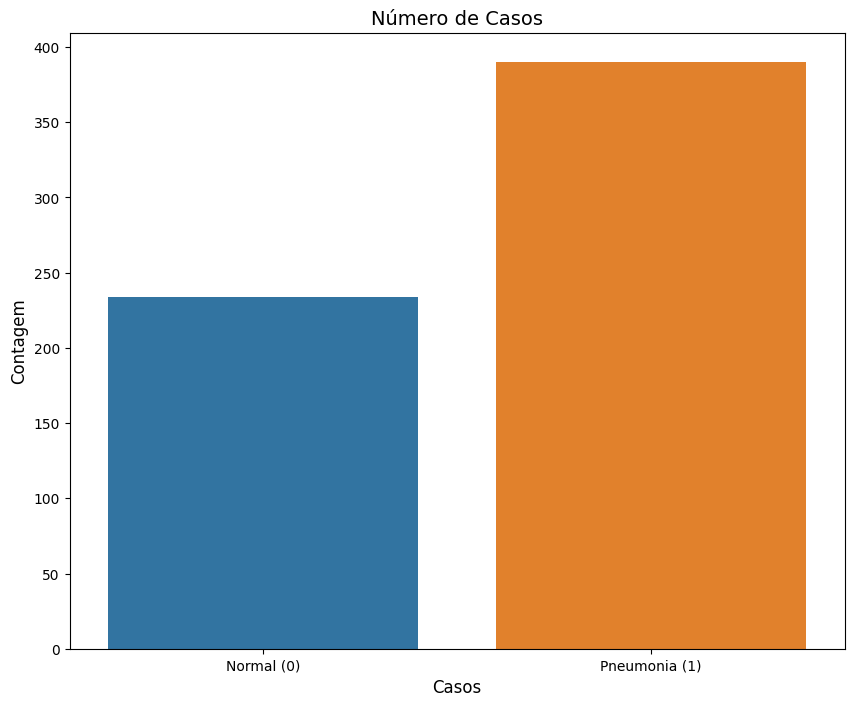

In [136]:
unique, counts = np.unique(test_labels, return_counts=True)
counts

plt.figure(figsize = (10,8))
sns.barplot(x = ['0', '1'], y = counts)
plt.title('Número de Casos', fontsize=14)
plt.xlabel('Casos', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(range(len(['0', '1'])), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

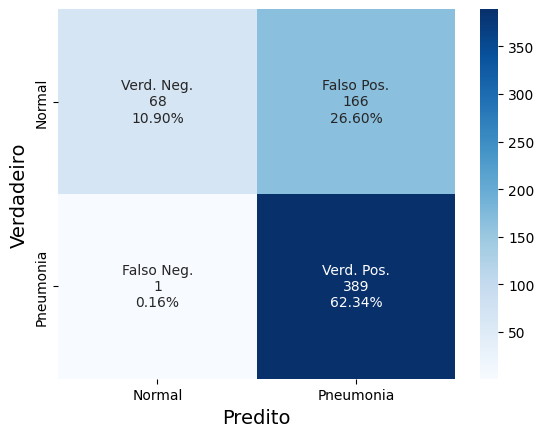

In [137]:
cm  = confusion_matrix(test_labels, preds)

group_names = ["Verd. Neg.", "Falso Pos.","Falso Neg.", "Verd. Pos."]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_perc = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_perc)]
labels = np.asarray(labels).reshape(2,2)


cm_plot = sns.heatmap(
    cm, annot = labels, fmt = "", cmap = 'Blues', 
    xticklabels = ['Normal', 'Pneumonia'], 
    yticklabels = ['Normal', 'Pneumonia']
)
cm_plot.set_xlabel('Predito', fontsize = 14)
cm_plot.set_ylabel('Verdadeiro', fontsize = 14)
plt.show()

In [138]:
print(classification_report(test_labels, preds, target_names = ['Normal', 'Pneumonia'], digits = 3))

              precision    recall  f1-score   support

      Normal      0.986     0.291     0.449       234
   Pneumonia      0.701     0.997     0.823       390

    accuracy                          0.732       624
   macro avg      0.843     0.644     0.636       624
weighted avg      0.808     0.732     0.683       624



In [139]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp+fp)
recall = tp / (tp+fn)

print("Recall do modelo é {:.3f}".format(recall))
print("Precisão do modelo é {:.3f}".format(precision))

Recall do modelo é 0.997
Precisão do modelo é 0.701


In [162]:
data_new_dir = Path('new_data')
new_test_dir = data_new_dir / 'new_test'

normal_cases_dir = new_test_dir / 'NORMAL'
pneumonia_cases_dir = new_test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.png')
pneumonia_cases = pneumonia_cases_dir.glob('*.png')

x_test_new = []
y_test_new = []



# Normal classes
for img in normal_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_test_new.append(img)
    y_test_new.append(label)
                      
# Pneumonia classes        
for img in pneumonia_cases:

    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))

    if img.shape[2] == 1:
        img = np.dstack([img, img, img])

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes = 2)
    x_test_new.append(img)
    y_test_new.append(label)

x_test_new = np.array(x_test_new)
y_test_new = np.array(y_test_new)

In [163]:
x_test_new.shape, y_test_new.shape

((8, 224, 224, 3), (8, 2))

In [164]:
new_test_loss, new_test_score = m1_.evaluate(x_test_new, y_test_new)
print(f"Recall no conjunto de teste é {new_test_score:.2f}")

1/1 [==============================] - 0s 50ms/step - loss: 3.5207 - recall_2: 0.6250
Recall no conjunto de teste é 0.62


In [165]:
new_preds = m1_.predict(x_test_new)
new_preds = np.argmax(new_preds, axis=-1)

new_test_labels = np.argmax(y_test_new, axis=-1)

print(new_test_labels.shape)
print(new_preds.shape)

1/1 [==============================] - 0s 45ms/step
(8,)
(8,)


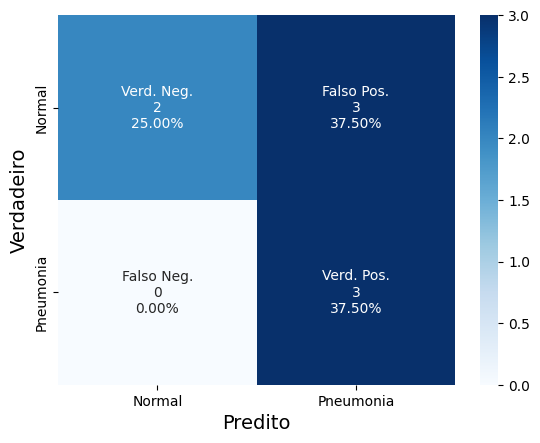

In [166]:
new_cm  = confusion_matrix(new_test_labels, new_preds)

group_names = ["Verd. Neg.", "Falso Pos.","Falso Neg.", "Verd. Pos."]
group_counts = ["{0:0.0f}".format(value) for value in new_cm.flatten()]
group_perc = ["{0:.2%}".format(value) for value in new_cm.flatten()/np.sum(new_cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_perc)]
labels = np.asarray(labels).reshape(2,2)


cm_plot = sns.heatmap(
    new_cm, annot = labels, fmt = "", cmap = 'Blues', 
    xticklabels = ['Normal', 'Pneumonia'], 
    yticklabels = ['Normal', 'Pneumonia']
)
cm_plot.set_xlabel('Predito', fontsize = 14)
cm_plot.set_ylabel('Verdadeiro', fontsize = 14)
plt.show()

In [167]:
print(classification_report(new_test_labels, new_preds, target_names = ['Normal', 'Pneumonia'], digits = 3))

              precision    recall  f1-score   support

      Normal      1.000     0.400     0.571         5
   Pneumonia      0.500     1.000     0.667         3

    accuracy                          0.625         8
   macro avg      0.750     0.700     0.619         8
weighted avg      0.812     0.625     0.607         8

